<a href="https://colab.research.google.com/github/yetinam/pyocto/blob/examples/01_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image](https://raw.githubusercontent.com/yetinam/pyocto/main/docs/_static/pyocto_logo_outlined.svg)

*This code is necessary on colab to install PyOcto. If PyOcto is already installed on your machine, you can skip this. In addition, we install PyArrow. This library is required for reading our example data in parquet format.*

In [ ]:
!pip install pyocto pyarrow

# Basics

This tutorial introduces the basics for using PyOcto. We will download a set of picks and station information. Next, we create an instance of the PyOcto picker. Finally, we associate the picks and visualize the outputs.

As a first step, we import the PyOcto library.

In [1]:
import pyocto
import pandas as pd
import datetime
import matplotlib.pyplot as plt

We will perform this example on readly compiled picks and station information. See the additional tutorial on how to compile the inputs for PyOcto. We download the data from our remote server.

## Input data

In [ ]:
!wget https://github.com/yetinam/pyocto/raw/main/tests/data/picks
!wget https://github.com/yetinam/pyocto/raw/main/tests/data/stations

In [2]:
picks = pd.read_parquet("picks")
stations = pd.read_parquet("stations")

Let's first inspect the picks. The picks are listed in a Pandas data frame. Each row denotes one pick, with a station, a phase (P or S) and a time. In addition, we have an event column, that is specific to this example. The picks in this example were synthetically generated, so we know the actual event-pick mapping. To ensure the associator can not use this, let's delete the event column.

In [3]:
picks

,station,phase,time,event
0,CX.PB01.,P,1970-01-01 01:05:30.844420,10
1,CX.PB08.,P,1970-01-01 01:05:35.634366,10
2,CX.PB02.,P,1970-01-01 01:05:35.728216,10
3,CX.PB07.,P,1970-01-01 01:05:37.399280,10
4,CX.PATCX.,P,1970-01-01 01:05:37.855473,10
...,...,...,...,...
1213,CX.HMBCX.,S,1970-01-02 00:32:16.051934,49
1214,CX.PB05.,S,1970-01-02 00:32:16.209676,49
1215,CX.PB12.,S,1970-01-02 00:32:50.429239,49
1216,CX.PB11.,P,1970-01-02 00:36:02.294781,-1


In [4]:
picks.drop(columns="event", inplace=True)

Next, we inspect the stations. Each station is describe by its id (the name of the station), the longitude, the latitude and the elevation in meters.

In [5]:
stations

,id,longitude,latitude,elevation
0,CX.PB01.,-69.48740,-21.043230,900.0
1,CX.PB02.,-69.89603,-21.319730,1015.0
2,CX.PB03.,-69.75310,-22.048470,1460.0
3,CX.PB04.,-70.14918,-22.333690,1520.0
4,CX.PB05.,-70.20235,-22.852830,1150.0
5,CX.PB06.,-69.57188,-22.705800,1440.0
6,CX.PB07.,-69.88618,-21.726670,1570.0
7,CX.PB08.,-69.15340,-20.141120,3060.0
8,CX.PB09.,-69.24192,-21.796380,1530.0
9,CX.PB10.,-70.55408,-23.513430,250.0


## Velocity models

Before creating the actual associator object, we need to define a velocity model. In this tutorial, we will use a simple homogeneous velocity model with a constant P and S velocity. This is a surprisingly good approximation but reaches it's limits for regions where seismicity is distributed across a large depth range. See the tutorial on velocity models for more details.

In [6]:
velocity_model = pyocto.VelocityModel0D(
    p_velocity=7.0,
    s_velocity=4.0,
    tolerance=2.0,
)

## The OctoAssociator class

The central object of PyOcto is the OctoAssociator class. There are different ways of creating an associator instance. In this tutorial, we use the `from_area` method, that automatically provides us with a local coordinate projection. We get to the details of this later.

In [7]:
associator = pyocto.OctoAssociator.from_area(
    lat=(-25, -18),
    lon=(-71.5, -68),
    zlim=(0, 200),
    time_before=300,
    velocity_model=velocity_model,
    n_picks=10,
    n_p_and_s_picks=4,
)

As mentioned above, PyOcto can automatically detect coordinate transforms. These translate from latitude and longitude to a local coordinate system in which (approximate) distances can be estimated using Pythagors theorem. Let's have a look at the inferred coordinate reference system.

In [8]:
associator.crs

<Projected CRS: +proj=tmerc +lat_0=-21.5 +lon_0=-69.75 +units=km + ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (kilometre)
- N[north]: Northing (kilometre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Using the `transform_stations` function, we can add the local coordinate columns (x, y, z) to the stations data frame.

In [9]:
associator.transform_stations(stations)
stations

,id,longitude,latitude,elevation,x,y,z
0,CX.PB01.,-69.48740,-21.043230,900.0,27.294830,50.551380,-0.900
1,CX.PB02.,-69.89603,-21.319730,1015.0,-15.150241,19.952907,-1.015
2,CX.PB03.,-69.75310,-22.048470,1460.0,-0.320004,-60.730576,-1.460
3,CX.PB04.,-70.14918,-22.333690,1520.0,-41.123292,-92.368236,-1.520
4,CX.PB05.,-70.20235,-22.852830,1150.0,-46.426533,-149.873692,-1.150
5,CX.PB06.,-69.57188,-22.705800,1440.0,18.300671,-133.531257,-1.440
6,CX.PB07.,-69.88618,-21.726670,1570.0,-14.089037,-25.104255,-1.570
7,CX.PB08.,-69.15340,-20.141120,3060.0,62.377492,150.336222,-3.060
8,CX.PB09.,-69.24192,-21.796380,1530.0,52.540503,-32.903341,-1.530
9,CX.PB10.,-70.55408,-23.513430,250.0,-82.123088,-223.191624,-0.250


As a last step before association, we need to transform the times of the picks from datetime objects to simple floats. The easiest way is using their unix timestamps.

In [10]:
picks["time"] = picks["time"].apply(lambda x: x.timestamp())
picks

,station,phase,time
0,CX.PB01.,P,3930.844420
1,CX.PB08.,P,3935.634366
2,CX.PB02.,P,3935.728216
3,CX.PB07.,P,3937.399280
4,CX.PATCX.,P,3937.855473
...,...,...,...
1213,CX.HMBCX.,S,88336.051934
1214,CX.PB05.,S,88336.209676
1215,CX.PB12.,S,88370.429239
1216,CX.PB11.,P,88562.294781


Now we are ready to run the associator. This is done with the `associate` method. This will take a few seconds.

In [11]:
events, assignments = associator.associate(picks, stations)

## The outputs of the association

Let's inspect the outputs of the association. First, we look at the events dataframe. It contains one event per row, with their timestamp, their coordinates and the number of picks. In addition, each event has been assigned an index.

In [12]:
events

,idx,time,x,y,z,picks
0,0,3913.955302,93.402649,43.692880,91.796875,17
1,1,4290.645031,-22.445598,67.949530,0.390625,22
2,2,4775.620481,71.681103,21.710292,114.453125,20
3,3,8150.495330,76.025412,-110.185239,100.390625,11
4,4,8336.688727,100.643164,-101.847016,99.609375,13
5,5,10754.730872,99.195061,-63.946001,99.609375,16
6,6,14672.649104,64.440587,116.462828,100.390625,17
7,7,19342.841836,-22.445598,-54.091737,84.765625,23
8,8,22649.999372,64.440587,44.450901,111.328125,17
9,9,28253.568883,-84.714030,171.040289,25.390625,22


Let's convert the times and locations back to a more readable format. Note that we need to specify the timezone to avoid offsets.

In [13]:
associator.transform_events(events)
events["time"] = events["time"].apply(datetime.datetime.fromtimestamp, tz=datetime.timezone.utc)
events

,idx,time,x,y,z,picks,latitude,longitude,depth
0,0,1970-01-01 01:05:13.955302+00:00,93.402649,43.692880,91.796875,17,-21.102996,-68.851051,91.796875
1,1,1970-01-01 01:11:30.645031+00:00,-22.445598,67.949530,0.390625,22,-20.886155,-69.965721,0.390625
2,2,1970-01-01 01:19:35.620481+00:00,71.681103,21.710292,114.453125,20,-21.302503,-69.059173,114.453125
3,3,1970-01-01 02:15:50.495330+00:00,76.025412,-110.185239,100.390625,11,-22.493384,-69.011195,100.390625
4,4,1970-01-01 02:18:56.688727+00:00,100.643164,-101.847016,99.609375,13,-22.416823,-68.772514,99.609375
5,5,1970-01-01 02:59:14.730872+00:00,99.195061,-63.946001,99.609375,16,-22.074684,-68.788915,99.609375
6,6,1970-01-01 04:04:32.649104+00:00,64.440587,116.462828,100.390625,17,-20.447005,-69.132458,100.390625
7,7,1970-01-01 05:22:22.841836+00:00,-22.445598,-54.091737,84.765625,23,-21.988371,-69.967347,84.765625
8,8,1970-01-01 06:17:29.999372+00:00,64.440587,44.450901,111.328125,17,-21.097398,-69.129808,111.328125
9,9,1970-01-01 07:50:53.568883+00:00,-84.714030,171.040289,25.390625,22,-19.953266,-70.559262,25.390625


In addition, PyOcto outputs a list of assignments. Each row is one pick, containing all information provided in the original pick dataframe. To columns have been added: the travel time residual from the localisation and an event index indicating which event the pick is associated with. Only picks that have been associated to an event are contained in this list.

In [14]:
assignments

,event_idx,pick_idx,residual,station,phase,time
0,0,5,0.077630,CX.HMBCX.,P,3938.212350
1,0,15,-0.927926,CX.HMBCX.,S,3955.341358
2,0,9,-0.796692,CX.MNMCX.,P,3948.894425
3,0,4,0.043814,CX.PATCX.,P,3937.855473
4,0,14,-0.537393,CX.PATCX.,S,3955.166534
...,...,...,...,...,...,...
859,47,1199,0.238868,CX.PB08.,P,88310.557580
860,47,1210,-0.341111,CX.PB08.,S,88331.194262
861,47,1200,-0.203682,CX.PB09.,S,88310.835368
862,47,1203,-0.445346,CX.PB11.,P,88317.437078


To supplement the picks with the event information, simply use the Pandas `merge` method like this:

In [15]:
pd.merge(events, assignments, left_on="idx", right_on="event_idx", suffixes=("", "_pick"))

,idx,time,x,y,z,picks,latitude,longitude,depth,event_idx,pick_idx,residual,station,phase,time_pick
0,0,1970-01-01 01:05:13.955302+00:00,93.402649,43.692880,91.796875,17,-21.102996,-68.851051,91.796875,0,5,0.077630,CX.HMBCX.,P,3938.212350
1,0,1970-01-01 01:05:13.955302+00:00,93.402649,43.692880,91.796875,17,-21.102996,-68.851051,91.796875,0,15,-0.927926,CX.HMBCX.,S,3955.341358
2,0,1970-01-01 01:05:13.955302+00:00,93.402649,43.692880,91.796875,17,-21.102996,-68.851051,91.796875,0,9,-0.796692,CX.MNMCX.,P,3948.894425
3,0,1970-01-01 01:05:13.955302+00:00,93.402649,43.692880,91.796875,17,-21.102996,-68.851051,91.796875,0,4,0.043814,CX.PATCX.,P,3937.855473
4,0,1970-01-01 01:05:13.955302+00:00,93.402649,43.692880,91.796875,17,-21.102996,-68.851051,91.796875,0,14,-0.537393,CX.PATCX.,S,3955.166534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,47,1970-01-02 00:31:22.029829+00:00,116.572298,-13.916662,93.359375,19,-21.621875,-68.624117,93.359375,47,1199,0.238868,CX.PB08.,P,88310.557580
860,47,1970-01-02 00:31:22.029829+00:00,116.572298,-13.916662,93.359375,19,-21.621875,-68.624117,93.359375,47,1210,-0.341111,CX.PB08.,S,88331.194262
861,47,1970-01-02 00:31:22.029829+00:00,116.572298,-13.916662,93.359375,19,-21.621875,-68.624117,93.359375,47,1200,-0.203682,CX.PB09.,S,88310.835368
862,47,1970-01-02 00:31:22.029829+00:00,116.572298,-13.916662,93.359375,19,-21.621875,-68.624117,93.359375,47,1203,-0.445346,CX.PB11.,P,88317.437078


Let's visualize the events. To avoid installing another library, we directly use our local coordinate transforms. For more proficient maps, e.g., with coastlines or other features, we recommend tools like Cartopy or PyGMT.

We plot the events with the depth color-coded. We see that the events form a clear subduction zone.

Text(0, 0.5, 'Northing [km]')

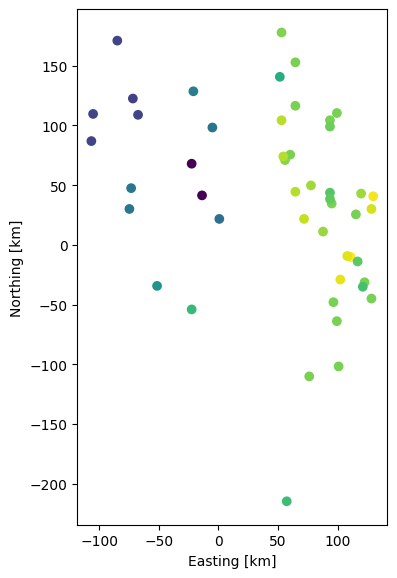

In [16]:
fig = plt.figure(figsize=(4, 8))
ax = fig.add_subplot()
ax.set_aspect("equal")

ax.scatter(events["x"], events["y"], c=events["z"])
ax.set_xlabel("Easting [km]")
ax.set_ylabel("Northing [km]")

## Concluding remarks

This notebook showed you the basics on how to use PyOcto but there's more to discover:

- check out the additional tutorials on interfaces (to GaMMA, REAL, SeisBench, Obspy, NonLinLoc) and on velocity models
- have a look at the documentation including a guide on how to choose the associator parameters at https://pyocto.readthedocs.org/
- visit the Github page to report issues or submit pull requests at https://github.com/yetinam/pyocto